In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
df_data = pd.read_csv('../data/train.csv')
df_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [3]:
X = df_data.copy().drop(['id', 'species'],axis='columns').values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1

In [4]:
device = torch.device('cpu')
if torch.backends.mps.is_available():
    device = torch.device('cpu')
elif torch.backends.cuda.is_built():
    device = torch.device('cuda')

In [5]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
t_train = torch.tensor(t_train, dtype=torch.float32, device=device)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

## Création du model

In [6]:
# X.shape[1] : le nombre de caractéristiques
model = nn.Sequential(
    nn.Linear(X.shape[1], 96, bias=True, dtype=torch.float32), # couche d'entrée
    nn.ReLU(),
    nn.Linear(96, 96, bias=True, dtype=torch.float32), # couche cachée
    nn.ReLU(),
    nn.Linear(96, species.size, bias=True, dtype=torch.float32), # couche de sortie
)
model.to(device=device)

Sequential(
  (0): Linear(in_features=192, out_features=96, bias=True)
  (1): ReLU()
  (2): Linear(in_features=96, out_features=96, bias=True)
  (3): ReLU()
  (4): Linear(in_features=96, out_features=99, bias=True)
)

## Test d'entrainement via une descente de gradiant 

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

In [8]:
num_epochs = 200
accuracy_train = []
loss_train = []
accuracy_test = []
loss_test = []
for epoch in range(num_epochs):
    accuracy = 0
    loss_epoch = 0
    for (x_sample, t_sample) in zip(X_train, t_train): # Dans une epoch nous parcourons toutes les données
        y = model(x_sample)
        loss = loss_function(y, t_sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
        accuracy += (torch.argmax(y) == torch.argmax(t_sample))
    accuracy = accuracy / X_train.shape[0]
    loss_train.append(loss_epoch / X_train.shape[0])
    accuracy_train.append(accuracy)
    
    y_test = model(X_test)
    loss = loss_function(y_test, t_test)
    loss_test.append(loss.item())
    accuracy_test.append(torch.sum(torch.eq(torch.argmax(y_test, dim=1), torch.argmax(t_test, dim=1))).item() / X_test.shape[0])
    
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.2f}%".format(epoch+1, num_epochs, loss_train[-1], accuracy_train[-1]*100))
    
    # si nous avons une précision supérieure à 99% nous arrêtons l'entraînement car nous sommes en train de
    # faire du surapprentissage
    if accuracy >= 0.99: 
        break

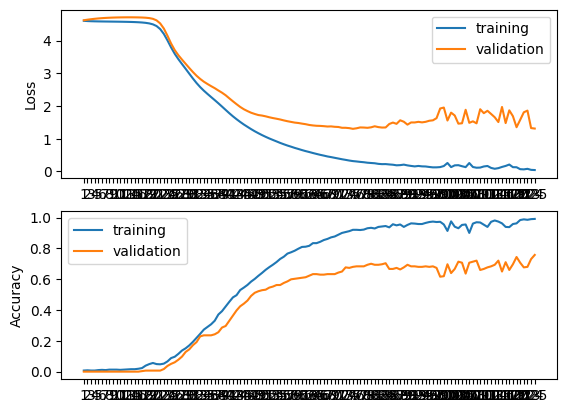

In [9]:
xdata = np.arange(1, len(loss_train) + 1)
plt.figure()
plt.subplot(2, 1, 1)
plt.ylabel('Loss')
plt.plot(xdata, loss_train, label='training')
plt.plot(xdata, loss_test, label='validation')
plt.xticks(xdata)
plt.legend()

plt.subplot(2, 1, 2)
plt.ylabel('Accuracy')
plt.plot(xdata, accuracy_train, label='training')
plt.plot(xdata, accuracy_test, label='validation')
plt.xticks(xdata)
plt.legend()
plt.show(block=False)